# Calculating how bots should place orders by targetting desired sigma

This is based on the assumption that we have bots A and B only. Bot A places a limit order. Bot B will eventually but soon place orders such that bot A's order is hit and this moves the mark price. 

We want mark price to follow log-normal distribution with volatility $\sigma$. How whould bots A and B place their orders? 

We can only hope the mark price to be log-normal over a time scale that is much longer than that at which the bots place orders. Let's say that the time scale for being log-normal is $T=1$ hour but the bots place orders every 1 second. Then the bots will place $N=3600$ orders in that time horizon. 

To be log-normal we want, by definition:
$$
\ln \frac{M_N}{M_0} = -\frac12 \sigma^2 T + \sigma \sqrt{T} Z\,,\,\,\, Z \sim N(0,1)\,,
$$
where here and elsewhere the equality is understood in the sense of distributions if needed.

Let us say that our mid-prices $M_i$ move as $M_i = M_{i-1} Y_i$ so that
$$
M_N = M_0 \prod_{i=1}^N Y_i\,.
$$
Then
$$
\ln \frac{M_N}{M_0} = \sum_{i=1}^N \ln Y_i\,.
$$

On the other hand, we know that for $N$ reasonably large (let's say more than 20) we can say that from the Central Limit Theorem 
$$
\frac1N \sum_{i=1}^N X_i \approx \hat \mu + \frac{\hat \sigma Z}{\sqrt{N}}\,,
$$
with $(X_i)_{i=1}^N$ i.i.d. with $\mathbb E X_1 = \hat \mu$ and $\mathbb V\text{ar}[X_1] = \hat \sigma$.

Thus taking appropriate random samples $(X_i)_{i=1}^N$ and $\ln Y_i := \frac{X_i}N$ we will have 
$$
\ln \frac{M_N}{M_0} = \sum_{i=1}^N \ln Y_i = \frac1N \sum_{i=1}^N X_i \approx \hat \mu + \frac{\hat \sigma Z}{\sqrt{N}}\,.
$$
That is, by taking $\hat \mu := -\frac12 \sigma^2 T$ and $\hat \sigma := \sigma \sqrt{T}$ our mid prices will have the desired distribution. For example we can take $X_1 \sim N(\hat \mu, \hat \sigma^2)$.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import binom

## Testing the above reasoning

In [2]:
# GBM parameters
M0 = 100.0
sigma = 1.0
T = 1.0/365.25/24 # this the year fraction corresponding to one hour
N = 3600 # place one order per second (as long as T above is one hour)

numMCSamples = 10000 # so we can consider some stats 

muHat = -0.5*sigma*sigma*T
sigmaHat = np.sqrt(N*T)*sigma

print("1 + muHat = "+str(1 + muHat))
print("sigma = "+str(sigma))

timeGrid = np.linspace(0,T,N)
priceLevels = np.zeros([numMCSamples,N])
priceLevels[:,0] = M0

1 + muHat = 0.9999429614419347
sigma = 1.0


Simplest case: we generate the shocks as normal r.v. that's just an initial sanity check

In [3]:
shocksX = np.random.normal(muHat, sigmaHat,(numMCSamples,N))

for i in range(0,N-1):
    Y = np.exp(shocksX[:,i]/N)
    priceLevels[:,i+1] = priceLevels[:,i]*Y

In [4]:
priceRatio = priceLevels[:,N-1]/priceLevels[:,0]
print("mean = %.3f" % np.mean(priceRatio))
sampleSigma = np.sqrt(np.var(priceRatio)/T)
print('sample stddev = %.3f, wanted sigma= %.3f' % (sampleSigma, sigma))

mean = 1.000
sample stddev = 0.998, wanted sigma= 1.000


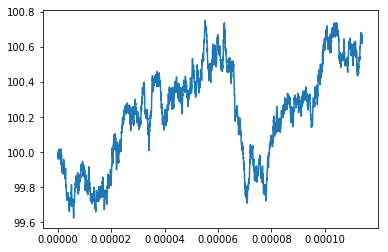

In [5]:
plt.plot(timeGrid, priceLevels[0,:])
plt.show()

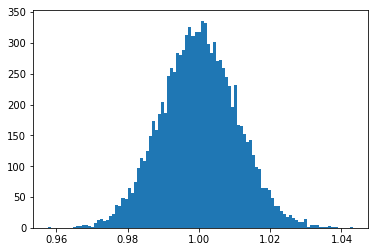

In [6]:
plt.hist(priceRatio, bins=100)
plt.show()

## Conclusion 

It seems fine. 

## What about discrete price levels?

mean = 1.000
sample stddev = 0.397, wanted sigma= 1.000


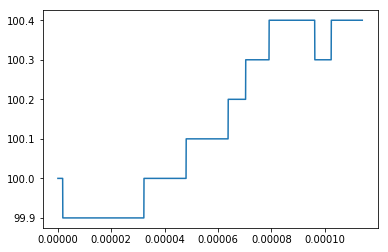

In [7]:
shocksX = np.random.normal(muHat, sigmaHat,(numMCSamples,N))

for i in range(0,N-1):
    Y = np.exp(shocksX[:,i]/N)
    priceLevels[:,i+1] = np.round(priceLevels[:,i]*Y,1)
    
priceRatio = priceLevels[:,N-1]/priceLevels[:,0]
print("mean = %.3f" % np.mean(priceRatio))
sampleSigma = np.sqrt(np.var(priceRatio)/T)
print('sample stddev = %.3f, wanted sigma= %.3f' % (sampleSigma, sigma))

plt.plot(timeGrid, priceLevels[0,:])
plt.show()


## Conclusion
We cannot deal with discrete prices by simply rounding / bucketing as that's reducing the desired volatility.

## Adapting the above argument to work with discrete price levels

Let $\delta > 0$ be a discrete price move we want to enforce. This could be the tick size or it can be several multiples of the tick size. 

Now we want our prices to move by exactly $\delta$ so our r.v. $X_i$ must take values in:
$$
\bigg\{ N\ln \frac{M_{i-1} + k\delta}{M_{i-1}} : k \in \mathbb Z \bigg\}\,.
$$

Let us note two things: one we only need enough degrees of freedom to choose $\hat \mu$ and $\hat \sigma$. We should be able to do that with a r.v. $X_1$ which can take exactly *three* values because then we are free to choos the probabilities $p_1$, $p_2$ (and $p_3 = (1-p_1-p_2)$). The second observation is that we can replace $M_{i-1}$ above by $M_0$. This shouldn't change the statistical properties too much and we're doing many massive simplifications elsewhere anyway. 

So we let $V_1 =  N\ln \frac{M_0 - \delta}{M_0}$, $V_2 =  N\ln \frac{M_0}{M_0}=0$ and $V_3 =  N\ln \frac{M_0 + \delta}{M_0}$ and we let $X_i$ to be the discrete r.v. taking values $\{V_1,V_2,V_3\}$ with probabilities $p_1,p_2,p_3$ which we determinte below to match $\hat \mu$ and $\hat \sigma$. 
Thus we want:
$$
\hat \mu = \mathbb E X_1 = p_1 V_1 + p_2 V_2 + p_3 V_3
$$
and
$$
\hat \sigma^2 + \hat \mu^2 = \mathbb E[X_1^2] = p_1 V_1^2 + p_2 V_2^2 + p_3 V_3^2\,.
$$

Note that this isn't the only way to achieve this. Another option would be to define $X_i$ to be: $p$ of going up or down and $M$ for the number of steps to move chosen according to some 1 parameter distribution. Again we could calculate $p$ and this parameter to match $\hat \mu$ and $\hat \sigma$.

The code below implements this (using an algorithm which forces the probabilities to stay +ve).

In [8]:
delta = 0.2

V = np.array([N*np.log((M0-delta)/M0),0.0,N*np.log((M0+delta)/M0)])
Vsq = V*V
matA = np.stack((V,Vsq,np.ones(3)))
#print(matA)
b = np.array([muHat,sigmaHat**2+muHat**2,1])
#print(b)

# probabilities = np.linalg.solve(matA,b)
#probabilities[0] = 1-np.sum(probabilities[1:3])
fun = lambda p: np.linalg.norm(np.dot(matA,p)-b) 
sol = minimize(fun, np.zeros(3), method='L-BFGS-B', bounds=[(0.,None) for x in range(3)])
probabilities = sol['x']/np.sum(sol['x']) # so they sum up to 1
print(probabilities)


shocksX = np.random.choice(V, (numMCSamples,N), p=probabilities)
for i in range(0,N-1):
    Y = np.exp(shocksX[:,i]/N)
    priceLevels[:,i+1] = np.round(priceLevels[:,i]*Y,3)
    
priceRatio = priceLevels[:,N-1]/priceLevels[:,0]
print("mean = %.3f" % np.mean(priceRatio))
sampleSigma = np.sqrt(np.var(priceRatio)/T)
print('sample stddev = %.3f, wanted sigma= %.3f' % (sampleSigma, sigma))




[0.00396099 0.99207801 0.003961  ]
mean = 1.000
sample stddev = 0.994, wanted sigma= 1.000


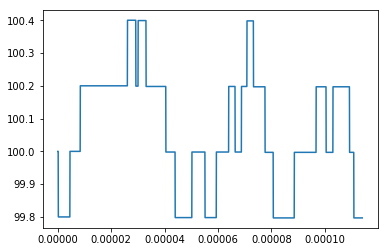

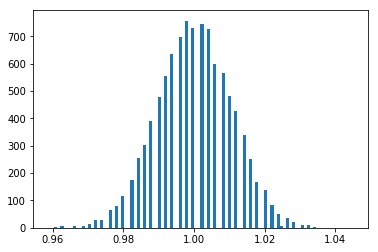

In [9]:
plt.plot(timeGrid, priceLevels[5,:])
plt.show()

plt.hist(priceRatio, bins=100)
plt.show()

In [10]:
# Another test

# GBM parameters
M0 = 100.0
sigma = 1.0
T = 1.0/365.25/24/60 # this the year fraction corresponding to one minute
N = 60 # place N orders per T

numMCSamples = 10000 # so we can consider some stats 

muHat = -0.5*sigma*sigma*T
sigmaHat = np.sqrt(N*T)*sigma

print("1 + muHat = "+str(1 + muHat))
print("sigma = "+str(sigma))

timeGrid = np.linspace(0,T,N)
priceLevels = np.zeros([numMCSamples,N])
priceLevels[:,0] = M0

1 + muHat = 0.9999990493573656
sigma = 1.0


[0.01584366 0.9683127  0.01584364]
mean = 1.000
sample stddev = 0.990, wanted sigma= 1.000


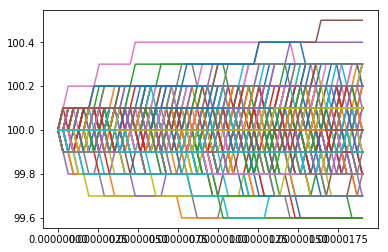

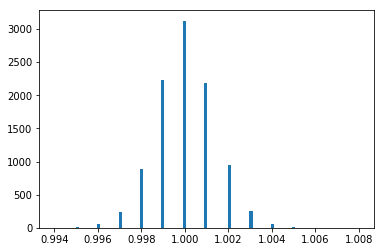

In [11]:
delta = 0.1

V = np.array([N*np.log((M0-delta)/M0),0.0,N*np.log((M0+delta)/M0)])
Vsq = V*V
matA = np.stack((V,Vsq,np.ones(3)))
#print(matA)
b = np.array([muHat,sigmaHat**2+muHat**2,1])
#print(b)

# probabilities = np.linalg.solve(matA,b)
#probabilities[0] = 1-np.sum(probabilities[1:3])
fun = lambda p: np.linalg.norm(np.dot(matA,p)-b) 
sol = minimize(fun, np.zeros(3), method='L-BFGS-B', bounds=[(0.,None) for x in range(3)])
probabilities = sol['x']/np.sum(sol['x']) # so they sum up to 1
print(probabilities)


shocksX = np.random.choice(V, (numMCSamples,N), p=probabilities)
for i in range(0,N-1):
    Y = np.exp(shocksX[:,i]/N)
    priceLevels[:,i+1] = np.round(priceLevels[:,i]*Y,3)
    
priceRatio = priceLevels[:,N-1]/priceLevels[:,0]
print("mean = %.3f" % np.mean(priceRatio))
sampleSigma = np.sqrt(np.var(priceRatio)/T)
print('sample stddev = %.3f, wanted sigma= %.3f' % (sampleSigma, sigma))



for i in range(0,1000):
    plt.plot(timeGrid, priceLevels[i,:])
plt.show()

plt.hist(priceRatio, bins=100)
plt.show()

## Let's try setting number of moves with Binomial distribution

Let us fix an integer $n>0$ which is the maximum number of moves of size $\delta$ we permit.
That is we will have $X_1 = N \ln \frac{M_0 + K\delta}{M_0}$ where $K\in \{-n,\ldots-1,0,1,\dots,n\}$ with the distribution of $K$ being
$$
\mathbb P(K=k) = p {n\choose k} \bar p^k (1-\bar p)^{n-k}\,,\,\,\,\text{for}\,\,\, k = 1,2,\ldots,n\,, 
$$
$$
\mathbb P(K=k) = (1-p) {n\choose k} \bar p^k (1-\bar p)^{n-k}\,,\,\,\,\text{for}\,\,\, k = -n,-(n-1),\ldots,1\,, 
$$
$$
\mathbb P(K=0) = p (1-\bar p)^n + (1-p)(1-\bar p)^n\,.
$$
We see that the distribution of $X_1$ depends on the choice of $p,\bar p$ and so we now want $\hat\mu = \mathbb E [X_1^{p,\bar p}]$ and $\hat \sigma = \mathbb V\text{ar}[X_1^{p,\bar p}]$. This is not linear in $p,\bar p$ but we can formulate it as minimization: find $p,\bar p$ such that
$$
f(p,\bar p) := |\hat\mu - \mathbb E [X_1^{p,\bar p}]|^2 + |\hat \sigma - \mathbb V\text{ar}[X_1^{p,\bar p}]|^2
$$
is minimized over $(0,1)\times(0,1)$.



In [78]:
# Test binomial moves

# GBM parameters
M0 = 100.0
sigma = 1.0
T = 1.0/365.25/24/60 # this the year fraction corresponding to one minute
N = 60 # place N orders per T

numMCSamples = 1000 # so we can consider some stats 

muHat = -0.5*sigma*sigma*T
sigmaHat = np.sqrt(N*T)*sigma

timeGrid = np.linspace(0,T,N)
priceLevels = np.zeros([numMCSamples,N])
priceLevels[:,0] = M0

delta = 0.1
nMoves = 5 # for the binomial distribution
V = N*np.log(np.linspace(M0 - nMoves*delta, M0+nMoves*delta, 2*nMoves+1)/M0)

In [79]:
def moveExpectationVariance(V, n, p, pBar):
    # the mid point in V is at V[nMoves]
    expectation = 0
    variance = 0
    for k in range(0,nMoves+1):
        binRvProb = binom(n,k)*np.power(pBar,k)*np.power(1-pBar,n-k)
        expectation += V[nMoves+k]*p*binRvProb # that's the moves up
        expectation += V[nMoves-k]*(1-p)*binRvProb # that's the moves down
        
        vSq = V[nMoves+k]*V[nMoves+k]
        variance += vSq*p*binRvProb # that's the moves up
        vSq = V[nMoves-k]*V[nMoves-k]
        variance += vSq*(1-p)*binRvProb # that's the moves down
    
    variance -= expectation*expectation
    
    return [expectation,variance]

print(moveExpectationVariance(V,nMoves,0.5,0.5))
print(V)

[-0.00022500135001490146, 0.027000246378162965]
[-0.30075251 -0.24048128 -0.18027054 -0.12012016 -0.06003002  0.
  0.05997002  0.11988016  0.17973054  0.23952128  0.29925249]


In [81]:
def fnToMin(probs):
    [expectation, variance] = moveExpectationVariance(V,nMoves, probs[0], probs[1])
    return np.power(muHat - expectation,2) + 100*np.power(sigmaHat*sigmaHat - variance,2)

sol = minimize(fnToMin, 0.5*np.ones(2), method='L-BFGS-B', bounds=[(0.,1.) for x in range(2)])
probabilities = sol['x']
print(probabilities)
[expectation, variance] = moveExpectationVariance(V,nMoves, probabilities[0], probabilities[1])
print("muHat=%.3f, expectation=%.3f, sigmaHat=%.3f, sigmaWeGet = %.3f" % (muHat,expectation,sigmaHat,np.sqrt(variance)))


[0.50037589 0.00622213]
muHat=-0.000, expectation=0.000, sigmaHat=0.011, sigmaWeGet = 0.011


In [82]:
upOrDown = np.random.binomial(1, probabilities[0], (numMCSamples,N))
upOrDown[upOrDown==0]=-1
K = upOrDown*np.random.binomial(nMoves, probabilities[1], (numMCSamples,N))
shocksX = np.zeros((numMCSamples,N))
for mcSample in range(0,numMCSamples):
    for tmStp in range(0,N):
        shocksX[mcSample,tmStp] = V[K[mcSample,tmStp]+nMoves]

mean = 1.000
sample stddev = 1.027, wanted sigma= 1.000


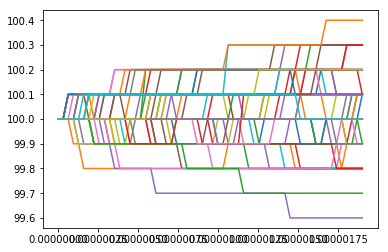

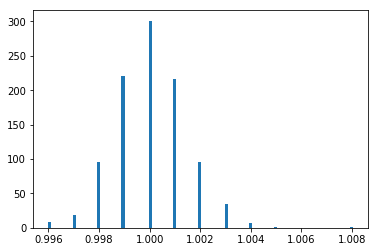

In [84]:
for i in range(0,N-1):
    Y = np.exp(shocksX[:,i]/N)
    priceLevels[:,i+1] = np.round(priceLevels[:,i]*Y,3)
    
priceRatio = priceLevels[:,N-1]/priceLevels[:,0]
print("mean = %.3f" % np.mean(priceRatio))
sampleSigma = np.sqrt(np.var(priceRatio)/T)
print('sample stddev = %.3f, wanted sigma= %.3f' % (sampleSigma, sigma))



for i in range(0,100):
    plt.plot(timeGrid, priceLevels[i,:])
plt.show()

plt.hist(priceRatio, bins=100)
plt.show()